# Interpreting PiFM data cubes

In this notebook, we will import a hyperspectral datacube of PiFM spectra of a polymer blend, take a random small sample of the entire cube, pull out individual wavelengths for visualization. 

We will also perform non-negative matrix factorization (NMF) on the sampled datacube to pull out two matrix components that correspond to the unmixed spectra of the pure polymers in this polymer blend. To characterize the error, we will compute the root-mean-squared-error (RMSE) between the NMF matrix components and the pure polymer spectra.

### Import necessary packages

In [11]:
## Data manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt

## Random numbers for sampling
from random import randint

## Non-negative matrix factorization
from sklearn.decomposition import NMF

### Load hyperspectral data for Polystyrene (PS) and DPPDTT blend

In [13]:
## Set a root directory for data
root_dir = "C:\\Users\\caitl\\Documents\\CHEME599_march2020\\20200506_HyperUnmixing_Data\\"

## Polymer blend image
blend = np.load(root_dir + 'subsample_image_64x64.npy')

## Pure DPPDTT
dppdtt = np.load(root_dir + 'dppdtt_ground_truth.npy')

## Pure PS
ps = np.load(root_dir + 'ps_ground_truth.npy')

### Lets take a look at a couple of single slices of the data cube

First, what is the shape of the datacube?

In [14]:
print('shape: ', blend.shape)

shape:  (64, 64, 1128)


If we want to use convolution neural nets in the future, or run long computations like NMF, it's worth to sample random portions of the larger image.

In [15]:
def sample(image, size):
    """
    creates a subsample of a 3-dimensional image
    Given a 3D image (x, y, z), this function creates a square subsample of a given size (size, size, z). The third dimension is preserved. Depends on Python random `randint` function.
    Parameters
    ------------
    image : Numpy array of 3 dimensions
        The first two dimensions of the array will be sampled/cropped; the third dimension will be preserved
    size : integer
        The size of the sample to be created
    Returns:
    ------------
    sample : Numpy array of 3 dimensions
        Subsample of original image of given size with intact third dimension
    """
    # define x and y dimensions where valid random uppler left corner may be initiated
    valid_range_x = image.shape[0] - size
    valid_range_y = image.shape[1] - size

    # define x and y coordinates of upper left corner of sampled image
    start_x = randint(0, valid_range_x)
    start_y = randint(0, valid_range_y)

    # grab sample out of original image
    sample = image[start_x:start_x + size,
                   start_y:start_y + size, :]

    return sample

### Take a 32x32 sample of the datacube

In [16]:
small_blend = sample(blend, 32)

Let's visualize a couple of slices of this datacube

In [27]:
def Wav_2_Im(image, wn):
    """ 
    Input a 3-dimensional 'image cube' and outputs a normalized slice at one wavenumber.

    Parameters
    ----------
    im : array_like image
         Input data.

    wn : integer
         Integer index value.

    Returns
    ----------
    slice : ndarray
            An image the same size as the input, but only 1 slice in the 3rd dimension.

    Notes
    ----------
    The input image is normalized by individually normalizing each slice in the 3rd dimension. 
    The normalization scheme is (im_slice - minimum of im_slice) / (maximum of im_slice - minimum of im_slice).
    There may be a different way to approach the normalization.

    """

    ## Set up storage for each normalized slice
    normalized = []
    
    ## Set up storage for the entire normalized image
    img_norm = np.empty(image.shape, dtype=np.float32)
    
    ## Loop through each slice in the image and normalize it by: (slice - slice min)/(slice max - slice min)
    for i in np.linspace(0, image.shape[2]-1, image.shape[2]-1).astype(np.int):
    
        ## pull out one slice
        im = image[:,:,i]
    
        ## normalize the slice
        normalized.append((im - np.min(im))/(np.amax(im) - np.min(im)))  

    ## Loop through each slice in the storage array and replace it with the normalized slice
    for i in np.linspace(0, image.shape[2]-1, image.shape[2]-1).astype(np.int):
    
        img_norm[:,:,i] = normalized[i-1]
    
    ## Pull out the normalized image at the wavenumber of interest
    slice = img_norm[:,:,wn-750]
  
    
    return slice

### Visualize a single slice

Text(0.5, 1.0, 'Image at wavenumber=250')

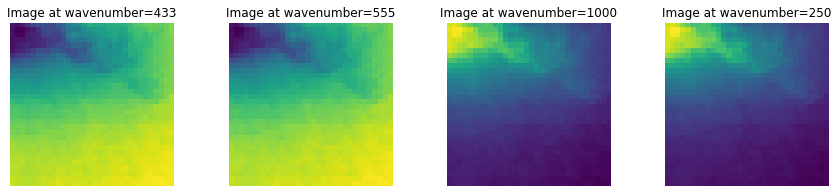

In [35]:
blend_433 = Wav_2_Im(small_blend, 433)
blend_555 = Wav_2_Im(small_blend, 555)
blend_1000 = Wav_2_Im(small_blend, 1000)
blend_250 = Wav_2_Im(small_blend, 250)


figs, axes = plt.subplots(1,4, figsize=(15,3))

for ax in axes:
    ax.axis('off') 
    
axes[0].imshow(blend_433, cmap='viridis')
axes[0].set_title("Image at wavenumber=433")

axes[1].imshow(blend_555, cmap='viridis')
axes[1].set_title("Image at wavenumber=555")

axes[2].imshow(blend_1000, cmap='viridis')
axes[2].set_title("Image at wavenumber=1000")

axes[3].imshow(blend_250, cmap='viridis')
axes[3].set_title("Image at wavenumber=250")

### Perform Non-negative Matrix Factorization on the small image cube

The NMF class comes from scikit-learn and requires a 2D array. This means we first need to flatten the data.

In [37]:
blend_2d = np.zeros((small_blend.shape[0]**2, small_blend.shape[2]))
for i in range(small_blend.shape[2]):
    blend_2d[:,i] = small_blend[:,:,i].flatten()

Now, we can perform the NMF fit function to find the decomposed matrix components. Since this is a blend of two polymers, we should have two matrix components. We need to first initialize the nmf

In [40]:
nmf = NMF(n_components=2, solver='cd', beta_loss='frobenius', tol=1e-4)

We can now fit and transform our image cube using NMF

In [43]:
product_matrix = nmf.fit_transform(np.abs(blend_2d)) # needs to be non-negative
matrix_components = nmf.components_

We should have a shape that is two components that are 1128 wavenumbers in length

In [46]:
matrix_components.shape

(2, 1128)

To compare the matrix components to the pure spectra, we need to use a function written by Jessica Kong to baseline correct the spectra. {I need to ask Maddie for Jessica's github repo to credit}

In [48]:
# baseline correction using a function that Jess Kong wrote
import numpy as np
import scipy.linalg as LA
import math

def baseline(y, deg=3, max_it=100, tol=1e-3):
    """Computes the baseline of a given data.
    Iteratively performs a polynomial fitting in the data to detect its
    baseline. At every iteration, the fitting weights on the regions with
    peaks are reduced to identify the baseline only.
    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges.
    max_it : int
        Maximum number of iterations to perform.
    tol : float
        Tolerance to use when comparing the difference between the current
        fit coefficient and the ones from the last iteration. The iteration
        procedure will stop when the difference between them is lower than
        *tol*.
    Returns
    -------
    ndarray
        Array with the baseline amplitude for every original point in *y*
    """
    order = deg + 1
    coeffs = np.ones(order)

    # try to avoid numerical issues
    cond = math.pow(y.max(), 1. / order)
    x = np.linspace(0., cond, y.size)
    base = y.copy()

    vander = np.vander(x, order)
    vander_pinv = LA.pinv2(vander)

    for _ in range(max_it):
        coeffs_new = np.dot(vander_pinv, y)

        if LA.norm(coeffs_new - coeffs) / LA.norm(coeffs) < tol:
            break

        coeffs = coeffs_new
        base = np.dot(vander, coeffs)
        y = np.minimum(y, base)

    return base

In [65]:
for i in range(matrix_components.shape[0]):
    base_i = baseline(matrix_components[i,:])
    matrix_components[i,:] = matrix_components[i,:] - base_i
    
print(matrix_components.shape)

(2, 1128)


Lets first visualize these two components separately, along with the pure polymer spectra

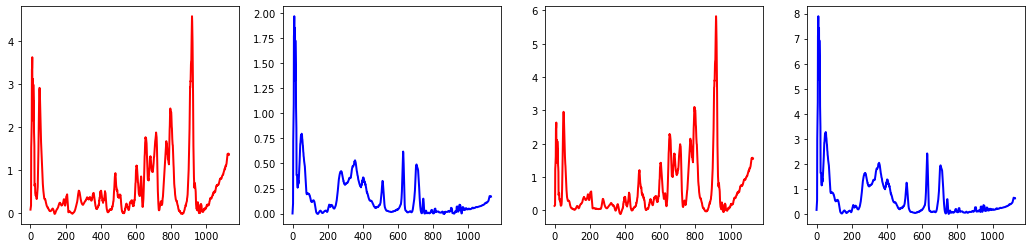

In [76]:
X = np.linspace(0, len(matrix_components[0]), 1128)

figs, axes = plt.subplots(ncols=4, figsize=(18,4))

axes[0].plot(X, matrix_components[0], lw=2, color='r')
axes[1].plot(X, matrix_components[1], lw=2, color='b')
axes[2].plot(X, dppdtt, lw=2, color='r')
axes[3].plot(X, ps, lw=2, color='b')

From the above plots, it looks like matrix component 1 is like dppdtt and matrix component 2 is like ps!

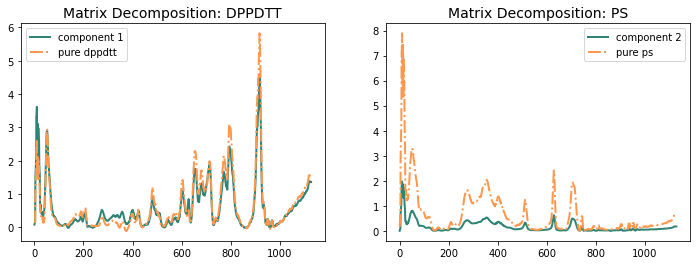

In [83]:
figs, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(X, matrix_components[0], lw=2, linestyle='-', color="#2F8475", label='component 1')
axes[0].plot(X, dppdtt, lw=2, linestyle='-.', color="#FF974C", label='pure dppdtt')
axes[0].set_title("Matrix Decomposition: DPPDTT", fontsize=14)
axes[0].legend()

axes[1].plot(X, matrix_components[1], lw=2, linestyle='-', color="#2F8475", label='component 2')
axes[1].plot(X, ps, lw=2, linestyle='-.', color="#FF974C", label='pure ps')
axes[1].set_title("Matrix Decomposition: PS", fontsize=14)
axes[1].legend()

### Compute the RMSE between the predicted spectrum from NMF decomposition and the pure spectrum

In [85]:
from sklearn.metrics import mean_squared_error as rmse

In [93]:
RMSE_dppdtt = rmse(dppdtt, matrix_components[0], squared=True)
RMSE_ps = rmse(ps, matrix_components[1], squared=True)
print('dppdtt', RMSE_dppdtt)
print('ps', RMSE_ps)

dppdtt 0.0569595344936103
ps 0.7119879939655631


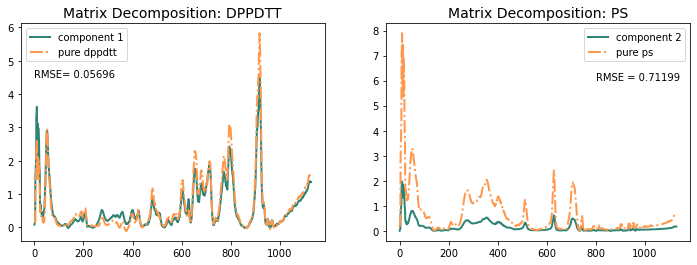

In [94]:
figs, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(X, matrix_components[0], lw=2, linestyle='-', color="#2F8475", label='component 1')
axes[0].plot(X, dppdtt, lw=2, linestyle='-.', color="#FF974C", label='pure dppdtt')
axes[0].text(0, 4.5, 'RMSE= 0.05696')
axes[0].set_title("Matrix Decomposition: DPPDTT", fontsize=14)
axes[0].legend()

axes[1].plot(X, matrix_components[1], lw=2, linestyle='-', color="#2F8475", label='component 2')
axes[1].plot(X, ps, lw=2, linestyle='-.', color="#FF974C", label='pure ps')
axes[1].text(800, 6, 'RMSE = 0.71199')
axes[1].set_title("Matrix Decomposition: PS", fontsize=14)
axes[1].legend()